In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns; sns.set()

from copy import deepcopy
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

# Implementing Blackjack environment

## Used Blackjack rules:

* The goal of blackjack is to beat the dealer's hand without going over 21.
Face cards are worth 10. Aces are worth 11.
* Each player starts with two cards, one of the dealer's cards is **hidden** until the end.
* To 'Hit' is to ask for another card. To 'Stick' is to hold your total and end your turn.
* If you go over 21 you bust, and the dealer wins regardless of the dealer's hand.
* If you are dealt 21 from the start (Ace & 10), you got a blackjack.
* The Dealer must hit as long as his total in under 17 and must Stick as he reaches 17 or higher.


## Used Reinforcement Learning Rules

* Winning state = +1 score
* Loosing state = -1 score
* Drawing state = 0 score

In [2]:
class Blackjack():

  def __init__(self):
    """
    Start the game by picking 2 cards for the player and the dealer.
    Dealer: 1 shown card + 1 hidden card
    Player: 2 shown cards
    """
    dealer_score, dealer_hidden_score = self.draw_two_cards_dealer()
    player_score = self.draw_two_cards_player()
    self.state = {"dealer_score": dealer_score, "dealer_hidden_score": dealer_hidden_score, "player_score": player_score} # initial state
    self.actions = ("hit", "stick")

    init_state = self.state.copy() # game history, recording (state, reward) and action of each step
    self.history = [init_state]



  def step(self, state, action):
        """
        Compute a step in Blackjack. 
        
        Input
        ----------
        state : state, the current state
        action : string, the action to pick
        
        Output
        -------
        state : state, new state reached given the picked action
        reward : int, the reward we get in this new state
        """
        self.history.append({"player": action})
        
        # player hits
        if action == "hit":
            value = self.draw_card()
            self.state['player_score'] = self.compute_new_score(value, current_score = self.state['player_score'])
            
            new_state = self.state.copy()
            
            if self.goes_bust(self.state['player_score']):
                # player goes bust/over 21
                reward = -1
                state = "terminal"
                self.history.append(new_state)
                self.history.append(state)
                return state, reward
            
            else:
                reward = 0
                self.history.append(new_state)
                return self.state, reward
            
        # player sticks   
        else:
            new_state = self.state.copy()
            self.history.append(new_state)
            
            state, reward = self.dealer_moves()
            return state, reward



  def draw_card(self):
        """
        Each draw from the deck results in a value between 1 and 13 (uniformly
        distributed) as follows:

        2 to 9 --> that Number card
        10 --> 10 or Jack or Queen or King
        11 --> Ace
        """
        value = random.randint(2, 11)
        return value



  def draw_two_cards_player(self):
        """
        Player Draws two cards at the start
        """
        initial_player_score = self.draw_card() + self.draw_card()
        return initial_player_score



  def draw_two_cards_dealer(self):
        """
        Dealers Draws two cards at the start
        BUT one of them should remain hidden until later
        """
        initial_dealer_score = self.draw_card()
        hidden_dealer_score = self.draw_card()
        return initial_dealer_score, hidden_dealer_score


  
  def goes_bust(self, score):
        """
        Tells if the player/dealer goes bust (over 21 points)
        
        Input
        ----------
        score : int, the current score
        
        Output
        -------
        bool : either goes bust 
        """
        return (score > 21)



  def compute_new_score(self, value, current_score):
        """
        Compute the new score given the value of the pulled card
        
        Input
        ----------
        value : int, card's value
        current_score : int, the current score to update
        
        Output
        -------
        new_score : integer       
        """
        new_score = current_score + value
        return new_score



  def dealer_moves(self): 
        """
        Fixed dealer policy
        
        Returns
        -------
        state : state, the terminal state of the game sequence
        reward : int, the reward obtained in the terminal state of the game sequence
        """
        # Add the hidden card score to the Dealer's score as his turns starts
        self.state['dealer_score'] += self.state['dealer_hidden_score']
        self.state['dealer_hidden_score'] = 0

        # dealer hits as long as his score is < 17
        while self.state['dealer_score'] < 17:
            value = self.draw_card()
            new_dealer_score = self.compute_new_score(value, current_score = self.state['dealer_score'])
            self.state['dealer_score'] = new_dealer_score
            
            new_state = self.state.copy()
            self.history.append({"dealer": "hit"})
            self.history.append(new_state)
            
            
            if self.goes_bust(new_dealer_score):
                # dealer goes bust, player wins
                reward = 1
                state = "terminal"
                self.history.append(state)
                return state, reward
            
        self.history.append({"dealer": "stick"})  
        
        player_score = self.state['player_score']
        dealer_score = self.state['dealer_score']  
        
        # score > 17 -> dealer sticks
        state = "terminal"
        self.history.append(state)
        if dealer_score < player_score: # player wins
            reward = 1
            return state, reward                    
        if dealer_score == player_score: # draw
            reward = 0
            return state, reward                 
        if dealer_score > player_score: # player loses
            reward = -1
            return state, reward


In [3]:
# Test a game of Blackjack where first the player Hits and Sticks, then the dealer hits
bj_game = Blackjack()
state_0 = bj_game.state
state_1 = bj_game.step(state_0, "hit")[0]
state_2 = bj_game.step(state=state_1, action="stick")
bj_game.history

[{'dealer_hidden_score': 8, 'dealer_score': 4, 'player_score': 22},
 {'player': 'hit'},
 {'dealer_hidden_score': 8, 'dealer_score': 4, 'player_score': 28},
 'terminal',
 {'player': 'stick'},
 {'dealer_hidden_score': 8, 'dealer_score': 4, 'player_score': 28},
 {'dealer': 'hit'},
 {'dealer_hidden_score': 0, 'dealer_score': 17, 'player_score': 28},
 {'dealer': 'stick'},
 'terminal']

# Sampling with Monte-Carlo Control (MCC) Method

In [4]:
# constants for player turn of the game
dealer_score_min = 1
dealer_score_max = 11
player_score_min = 1
player_score_max = 22

In [5]:
class MCC():

  def __init__(self, exploration_constant, n_episodes):
    self.actions = ("hit", "stick")
    self.N_0 = exploration_constant # constant parameter (influence the exploration/exploitation behavior when starting to learn)
    self.n_episodes = n_episodes    # number of games to sample in order to make the agent learn

    self.Q = self.init_to_zeros()   # init Q function to zeros
    self.N = self.init_to_zeros()   # init N to zeros
    self.policy = "random"          # arbitrarily init the MC learning with a random policy 



  def learn_q_value_function(self):
        """
        Update the Q function until optimal value function is reached.
        
        Output
        ----------
        Q : {state: (action)}, Q value for every state-action pair
        """
        for i in range(self.n_episodes):
            episode = self.play_episode() # run an episode using current policy
            self.policy = "e_greedy"      # policy switch from random to epsilon greedy
            for step in episode: 
                state, action, reward = step
                self.increment_counter(state, action) # increment state-action counter 
                self.update_Q(state, action, reward)  # update the Q value
                
        return self.Q 



  def init_to_zeros(self):
        """
        Init the Q function and the incremental counter N at 0 for every state-action pairs.
        
        Output
        ----------
        lookup_table : {state: (action)}, a dictionnary of states as keys and actions as value
        """
        dealer_scores = np.arange(dealer_score_min, dealer_score_max+1)
        player_scores = np.arange(player_score_min, player_score_max+1)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]       
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  
            
        return lookup_table



  def play_episode(self):
        """
        Run a complete Blackjack game sequence given a policy. 
        
        Output
        ----------
        episode : [(state, action, reward)], a list of (statec, action, reward)
        """
        bj_game = Blackjack()            # init a game sequence
        state = bj_game.state.copy()     # init state
        episode = []                     # list of the steps of the game sequence
        while state != "terminal":      
            # pick an action regarding the current state and policy
            if self.policy == "random":
                action = self.random_policy()
            if self.policy == "e_greedy":
                action = self.e_greedy_policy(state)
            next_state, reward = deepcopy(bj_game.step(state, action))
            step = (state, action, reward)
            state = next_state
            episode.append(step)   
            
        return episode



  def update_Q(self, state, action, reward):
        """
        Update Q value towards the error term. 
        
        Input
        ----------
        state : state, the current score
        action : string, the current score
        reward : int, the current score
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        
        # The learning rate, decaying regarding the number of times an action-state pair 
        # has been explored. It scale the amount of modification we want to bring to 
        # the Q value function.
        alpha_t = 1 / self.get_state_action_counter(state, action)
        
        # We adjust the Q value towards the reality (observed) minus what we estimated.
        # This term is usually descrived as the error term.
        self.Q[lookup_state][action] += alpha_t * (reward - self.Q[lookup_state][action]) 
        
        return None



  def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.
        
        Input
        ----------
        state : state, the current score
        action : string, the current score
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        self.N[lookup_state][action] += 1        

        return None



  def random_policy(self):
        """
        Return an action follwing a random policy (state free).
        
        Output
        ----------
        action : string, random action
        """
        action = random.choice(self.actions)
        
        return action
     
     

  def e_greedy_policy(self, state):
        """
        Return an action given an epsilon greedy policy (state based).  
        
        Input
        ----------
        state : state, state where we pick the action
        
        Output
        ----------
        action : string, action from epsilon greedy policy
        """
        e = self.N_0/(self.N_0 + self.get_state_counter(state))
        if e > random.uniform(0, 1): 
            action = random.choice(self.actions)
        else:  
            action = self.get_action_w_max_value(state)
            
        return action
    


  def get_action_w_max_value(self, state):
        """
        Return the action with the max Q value at a given state.
        
        Input
        ----------
        state : state, state 
        
        Output
        ----------
        action : string, action from epsilon greedy policy
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get) 
            return action
    



  def get_state_counter(self, state):
        """
        Return the counter for a given state.
        
        Input
        ----------
        state : state, state 
        
        Output
        ----------
        counter : int, the number of times a state as been explored
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        counter = np.sum(list(self.N[lookup_state].values()))  
        
        return counter
    


  def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.
        
        Input
        ----------
        state : state 
        action : string
        
        Output
        ----------
        counter : int, the number of times an action-state pair as been explored
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        counter = self.N[lookup_state][action]
        
        return counter

## Printing Lookup Table Example

In [6]:
# Lookup Table for rewards after 100 games
mc = MCC(exploration_constant=100, n_episodes=100)
mc.learn_q_value_function()

{(1, 1): {'hit': 0, 'stick': 0},
 (1, 2): {'hit': 0, 'stick': 0},
 (1, 3): {'hit': 0, 'stick': 0},
 (1, 4): {'hit': 0, 'stick': 0},
 (1, 5): {'hit': 0, 'stick': 0},
 (1, 6): {'hit': 0, 'stick': 0},
 (1, 7): {'hit': 0, 'stick': 0},
 (1, 8): {'hit': 0, 'stick': 0},
 (1, 9): {'hit': 0, 'stick': 0},
 (1, 10): {'hit': 0, 'stick': 0},
 (1, 11): {'hit': 0, 'stick': 0},
 (1, 12): {'hit': 0, 'stick': 0},
 (1, 13): {'hit': 0, 'stick': 0},
 (1, 14): {'hit': 0, 'stick': 0},
 (1, 15): {'hit': 0, 'stick': 0},
 (1, 16): {'hit': 0, 'stick': 0},
 (1, 17): {'hit': 0, 'stick': 0},
 (1, 18): {'hit': 0, 'stick': 0},
 (1, 19): {'hit': 0, 'stick': 0},
 (1, 20): {'hit': 0, 'stick': 0},
 (1, 21): {'hit': 0, 'stick': 0},
 (1, 22): {'hit': 0, 'stick': 0},
 (2, 1): {'hit': 0, 'stick': 0},
 (2, 2): {'hit': 0, 'stick': 0},
 (2, 3): {'hit': 0, 'stick': 0},
 (2, 4): {'hit': 0, 'stick': 0},
 (2, 5): {'hit': 0, 'stick': 0},
 (2, 6): {'hit': 0.0, 'stick': 0},
 (2, 7): {'hit': 0, 'stick': 0},
 (2, 8): {'hit': 0, 'stick':

## Ploting Q values for visualisation

In [7]:
def plot_Q(n_episodes):
    mc = MCC(exploration_constant=100, n_episodes=n_episodes)
    mc.learn_q_value_function()
    
    fig = plt.figure(figsize=(player_score_max, dealer_score_max))
    ax = fig.gca(projection='3d')

    # Make data.
    dealer_showing = np.arange(dealer_score_min, dealer_score_max+1)
    player_score = np.arange(player_score_min, player_score_max+1)
    dealer_showing, player_score = np.meshgrid(dealer_showing, player_score)

    max_Q = np.ndarray(shape=(player_score_max, dealer_score_max))
    for state in mc.Q:
        max_Q[state[1]-1][state[0]-1] = max(mc.Q[state].values())


    # Plot the surface.
    surf = ax.plot_surface(dealer_showing, player_score, max_Q, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize plot
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


    plt.xlabel('Dealer showing', fontsize=12)
    plt.ylabel('Player score', fontsize=12)
    plt.title('Optimal Q value function', fontsize=16)
    
    plt.xticks(np.arange(dealer_score_min, dealer_score_max))
    plt.yticks(np.arange(player_score_min, player_score_max))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

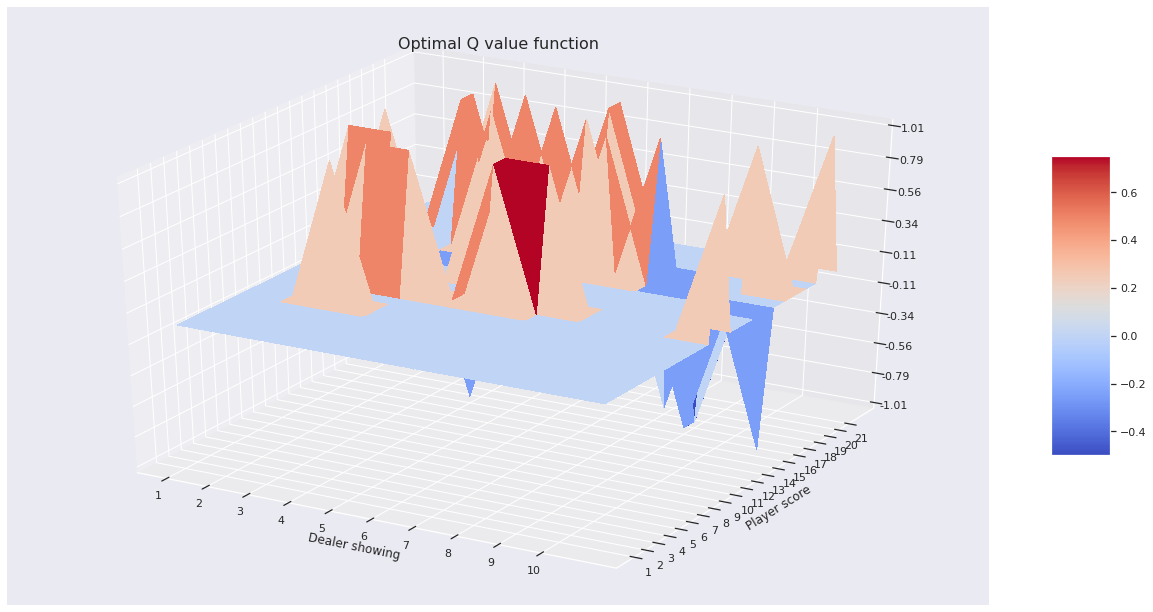

In [8]:
# Ploting Q for a 100 games
plot_Q(n_episodes=100)

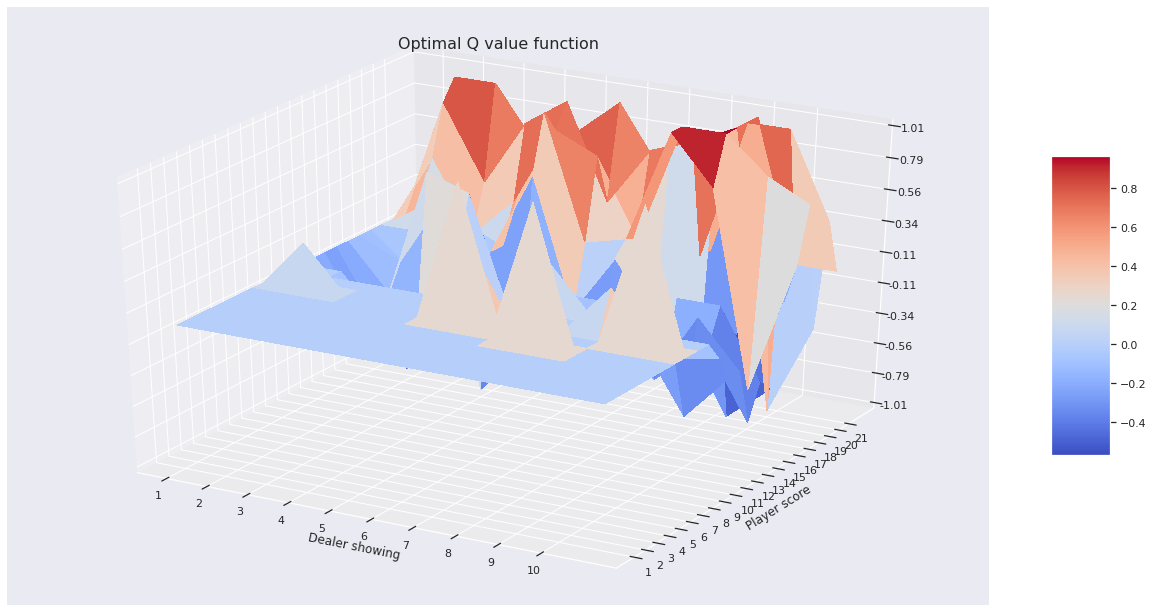

In [9]:
# Ploting Q for a 1000 games
plot_Q(n_episodes=1000)

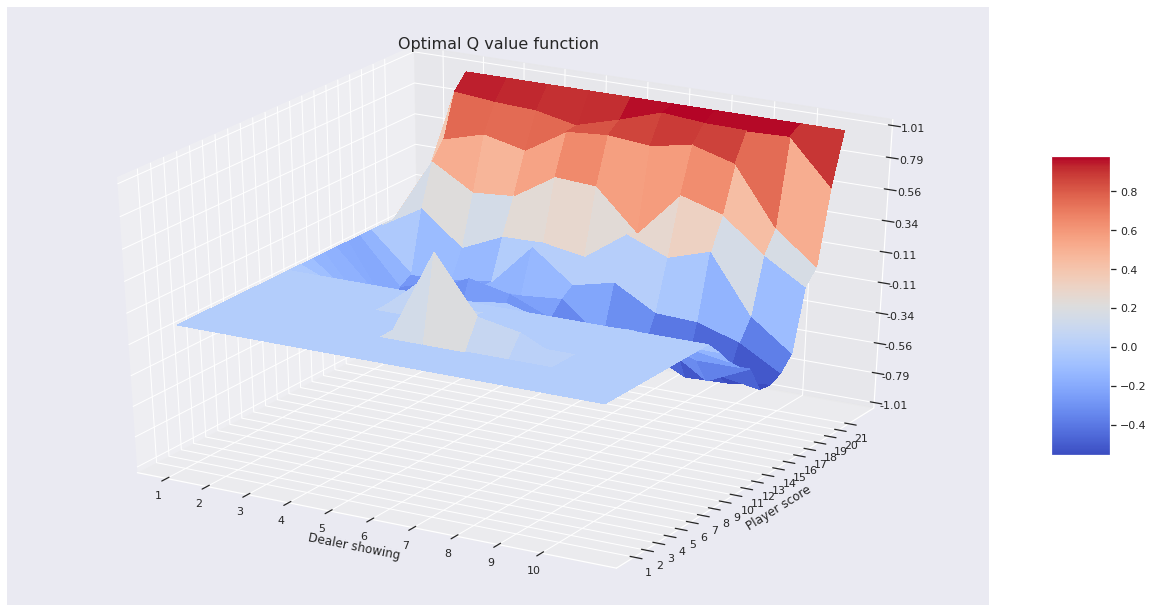

In [10]:
# Ploting Q for a 10 000 games
plot_Q(n_episodes=10_000)

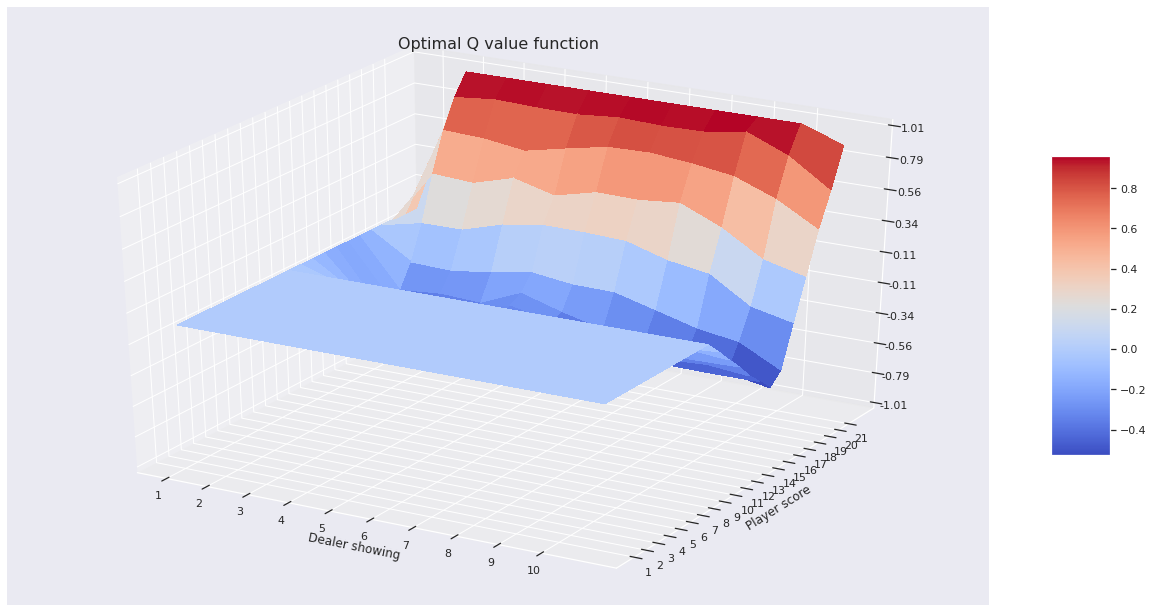

In [11]:
# Ploting Q for a 100 000 games
plot_Q(n_episodes=100_000)

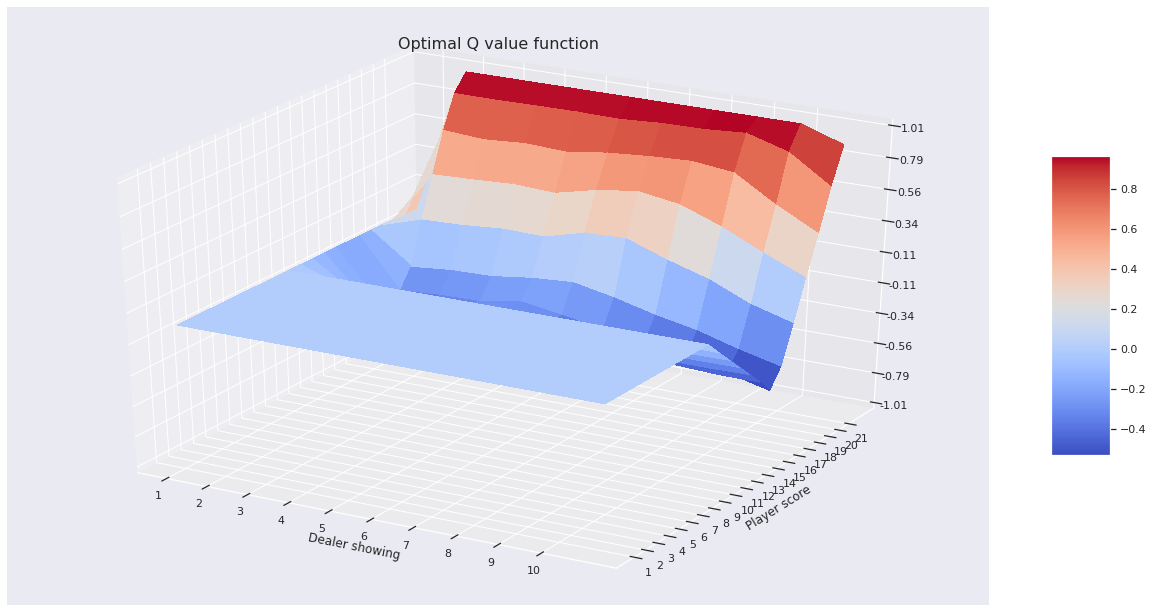

In [12]:
# Ploting Q for a 1 000 000 games
plot_Q(n_episodes=1_000_000)

### Comments

We can observe that, as we increase the number of games played, the Q value variance decreases and becomes more "even". At 100 games, the variance is so important that we can observe spikes on the chart.

## Finding optimal actions from MCC

In [13]:
def plot_opt_policy(n_episodes):
    mc = MCC(exploration_constant=100, n_episodes=n_episodes)
    mc.learn_q_value_function()
    df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
    states = list(mc.Q.keys())
    for i in range(len(states) - dealer_score_max*2):
        best_action = max(mc.Q[states[i]], key=mc.Q[states[i]].get)
        df.loc[i] = (states[i][0], states[i][1], best_action)

    df_pivot = df.pivot("player_score", "dealer_showing", "best_action")
    return df_pivot

In [14]:
# best strategies learnt from a 1 000 games
plot_opt_policy(n_episodes=1000)

dealer_showing,1,2,3,4,5,6,7,8,9,10,11
player_score,,,,,,,,,,,
1,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
2,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
3,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
4,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
5,hit,hit,stick,hit,stick,hit,hit,hit,hit,hit,hit
6,hit,hit,hit,stick,hit,hit,hit,hit,hit,hit,hit
7,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
8,hit,hit,hit,hit,hit,stick,hit,hit,hit,hit,hit
9,hit,hit,stick,hit,hit,hit,hit,stick,hit,hit,hit


In [15]:
# best strategies learnt from a 10 000 games
plot_opt_policy(n_episodes=10_000)

dealer_showing,1,2,3,4,5,6,7,8,9,10,11
player_score,,,,,,,,,,,
1,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
2,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
3,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
4,hit,hit,hit,hit,hit,hit,hit,hit,stick,hit,hit
5,hit,hit,hit,stick,hit,hit,hit,hit,hit,hit,hit
6,hit,hit,hit,hit,stick,hit,hit,hit,hit,hit,hit
7,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
8,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
9,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit


In [16]:
# best strategies learnt from a 100 000 games
plot_opt_policy(n_episodes=100_000)

dealer_showing,1,2,3,4,5,6,7,8,9,10,11
player_score,,,,,,,,,,,
1,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
2,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
3,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
4,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
5,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
6,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
7,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
8,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
9,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit


In [17]:
# best strategies learnt from a 1 000 000 games
plot_opt_policy(n_episodes=1_000_000)

dealer_showing,1,2,3,4,5,6,7,8,9,10,11
player_score,,,,,,,,,,,
1,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
2,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
3,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
4,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
5,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
6,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
7,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
8,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
9,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit


# Temporal Difference (TD) learning with SARSA

In [18]:
class SARSA():
    
  def __init__(self, lamb, n_episodes, N_0=100):
        self.actions = ("hit", "stick") 
        self.lamb = lamb                # lambda parameter of the SARSA algorithm
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior when starting to learn)
        
        self.Q = self.init_to_zeros()   # init Q function to zeros
        self.N = self.init_to_zeros()   # init the counter traces to zeros
        
        # used for plot
        self.Q_history = {} 
        self.list_n_episodes = np.linspace(10, n_episodes-1, 30, dtype=int)



  def learn_q_value_function(self):
        """
        Update the Q function until optimal value function is reached.
        
        Output
        ----------
        Q : {state: (action)}, Q value for every state-action pair
        """
        for i in range(self.n_episodes):
            self.eligibilty_traces = self.init_to_zeros()    # init eligibilty traces to zeros
            bj_game = Blackjack()                            # init a game sequence
            state = bj_game.state.copy()                     # init state    
            action = self.e_greedy_policy(state)             # pick a first action
            self.increment_counter(state, action)
            
            while state != "terminal":      
                next_state, reward = deepcopy(bj_game.step(state, action))
                
                if next_state == "terminal":
                    next_action = None
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                    
                else:   
                    next_action = self.e_greedy_policy(next_state)   
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                    self.increment_counter(next_state, next_action)
                                                

                self.increment_eligibility_traces(state, action)
                self.update_step(delta)
                
                action = next_action
                state = next_state

            
            if i in self.list_n_episodes: 
                self.Q_history[i] = deepcopy(self.Q)
            
        return self.Q 


                
  def init_to_zeros(self):
        """
        Init the Q function and the incremental counter N at 0 for every state-action pairs.
        
        Output
        ----------
        lookup_table : {state: (action)}, a dictionnary of states as keys and actions as value
        """
        dealer_scores = np.arange(dealer_score_min, dealer_score_max+1)
        player_scores = np.arange(player_score_min, player_score_max+1)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]       
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  
            
        return lookup_table


 
  def update_step(self, delta):
        """
        Update the Q value towards the error term and eligibility traces . 
        
        Input
        ----------
        delta : float, the delta factor of the current state-action pair
        """
        for state in self.Q.keys():
            for action in self.actions:
                alpha = 1 / (self.get_state_action_counter(state, action) + 1)
                self.Q[state][action] += alpha * delta * self.eligibilty_traces[state][action]
                # Here is where the lambda parameter intervene. The higher, the longer the eligibility trace
                # associated to a state-action pair will remain 
                self.eligibilty_traces[state][action] *= self.lamb
        return None


    
  def compute_delta(self, state, action, next_state, next_action, reward):
        """
        Update Q value towards the error term, it is the TD learning step. 
        
        Input
        ----------
        state : state, the current state
        action : string, the current action
        reward : int, the current score
        next_state : int, the state we end after taking the action
        next_action : int, the action we take in next state following the policy (e greedy)
        
        Output
        ----------
        delta : float, the TD error term
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        if next_state == "terminal":
            delta = reward - self.Q[lookup_state][action]
        else:
            next_lookup_state = (next_state["dealer_score"], next_state["player_score"])
            delta = reward + self.Q[next_lookup_state][next_action] - self.Q[lookup_state][action]
        return delta



  def increment_eligibility_traces(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.
        
        Input
        ----------
        state : state, the current score
        action : string, the current score
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        self.eligibilty_traces[lookup_state][action] += 1  
        return None


    
  def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.
        
        Input
        ----------
        state : state, the current score
        action : string, the current score
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        self.N[lookup_state][action] += 1 
        return None


    
  def random_policy(self):
        """
        Return an action follwing a random policy (state free).
        
        Output
        ----------
        action : string, random action
        """
        action = random.choice(self.actions)
        
        return action


          
  def e_greedy_policy(self, state):
        """
        Return an action given an epsilon greedy policy (state based).  
        
        Input
        ----------
        state : state, state where we pick the action
        
        Output
        ----------
        action : string, action from epsilon greedy policy
        """
        e = self.N_0/(self.N_0 + self.get_state_counter(state))
        if e > random.uniform(0, 1): 
            action = random.choice(self.actions)
        else:  
            action = self.get_action_w_max_value(state)
            
        return action


    
  def get_action_w_max_value(self, state):
        """
        Return the action with the max Q value at a given state.
        
        Input
        ----------
        state : state, state 
        
        Output
        ----------
        action : string, action from epsilon greedy policy
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get) 
            return action


    
  def get_state_counter(self, state):
        """
        Return the counter for a given state.
        
        Input
        ----------
        state : state, state 
        
        Output
        ----------
        counter : int, the number of times a state as been explored
        """
        lookup_state = (state["dealer_score"], state["player_score"])
        counter = np.sum(list(self.N[lookup_state].values()))  
        
        return counter


    
  def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.
        
        Input
        ----------
        state : state 
        action : string
        
        Output
        ----------
        counter : int, the number of times an action-state pair as been explored
        """
        counter = self.N[state][action]
        
        return counter

In [19]:
# Lookup Table for rewards after 100 games using TD
sarsa = SARSA(lamb=0.9, n_episodes=100, N_0=100)
sarsa.learn_q_value_function()

{(1, 1): {'hit': 0.0, 'stick': 0.0},
 (1, 2): {'hit': 0.0, 'stick': 0.0},
 (1, 3): {'hit': 0.0, 'stick': 0.0},
 (1, 4): {'hit': 0.0, 'stick': 0.0},
 (1, 5): {'hit': 0.0, 'stick': 0.0},
 (1, 6): {'hit': 0.0, 'stick': 0.0},
 (1, 7): {'hit': 0.0, 'stick': 0.0},
 (1, 8): {'hit': 0.0, 'stick': 0.0},
 (1, 9): {'hit': 0.0, 'stick': 0.0},
 (1, 10): {'hit': 0.0, 'stick': 0.0},
 (1, 11): {'hit': 0.0, 'stick': 0.0},
 (1, 12): {'hit': 0.0, 'stick': 0.0},
 (1, 13): {'hit': 0.0, 'stick': 0.0},
 (1, 14): {'hit': 0.0, 'stick': 0.0},
 (1, 15): {'hit': 0.0, 'stick': 0.0},
 (1, 16): {'hit': 0.0, 'stick': 0.0},
 (1, 17): {'hit': 0.0, 'stick': 0.0},
 (1, 18): {'hit': 0.0, 'stick': 0.0},
 (1, 19): {'hit': 0.0, 'stick': 0.0},
 (1, 20): {'hit': 0.0, 'stick': 0.0},
 (1, 21): {'hit': 0.0, 'stick': 0.0},
 (1, 22): {'hit': 0.0, 'stick': 0.0},
 (2, 1): {'hit': 0.0, 'stick': 0.0},
 (2, 2): {'hit': 0.0, 'stick': 0.0},
 (2, 3): {'hit': 0.0, 'stick': 0.0},
 (2, 4): {'hit': 0.0, 'stick': 0.5},
 (2, 5): {'hit': 0.0, 'st

# Comparing MCC and SARSA using Mean Squared Error (MSE)

In [20]:
# Mean Squared Error (MSE) calculation
def MSE(optimal_Q, sarsa_Q):
    actions = ["hit", "stick"]
    mse = 0
    for state in optimal_Q.keys():
        for action in actions:
            mse += (sarsa_Q[state][action] - optimal_Q[state][action])**2       
    mse *= (1 / len(action)*len(optimal_Q.keys()))
    return mse

In [21]:
# Plotting the MSE values
def plot_mse(optimal_Q, n_episodes, list_lambdas):
    df = pd.DataFrame(columns=["mse", "n_episodes", "lambda"])
    #list_lambdas = np.linspace(0,1,11)
    i=0

    for lamb in list_lambdas:
        sarsa_Q = SARSA(lamb=lamb, n_episodes=n_episodes, N_0=100)
        sarsa_Q.learn_q_value_function()
        list_n_episodes = sarsa_Q.list_n_episodes

        for n_episodes in list_n_episodes:
            mse = MSE(optimal_Q, sarsa_Q.Q_history[n_episodes])        
            lamb = round(lamb, 2)
            df.loc[i] = (mse, int(n_episodes), f"lambda = {lamb}")
            i+=1

    fig_dims = (12, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.lineplot(x="n_episodes", y="mse", hue="lambda", data=df)

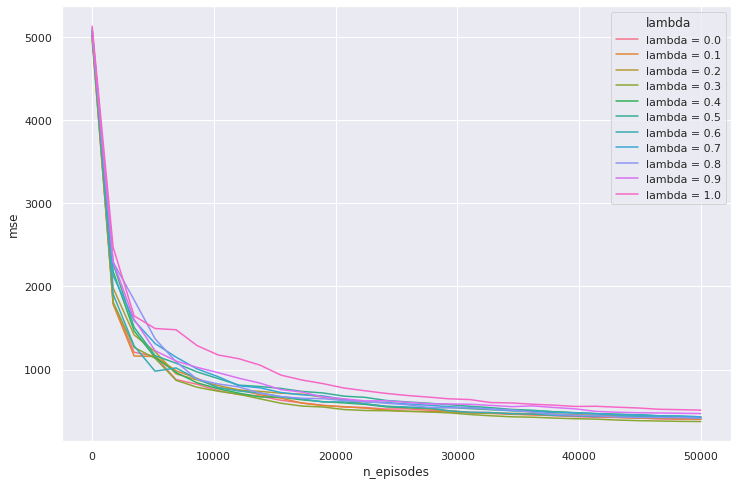

In [22]:
# Test Case with 50 000 games for different Lambda values to Plot and Compare
mc = MCC(exploration_constant=100, n_episodes=1_000_000)
optimal_Q = mc.learn_q_value_function()

list_lambdas = np.linspace(0, 1, 11)
n_episodes = 50_000
plot_mse(optimal_Q, n_episodes=n_episodes, list_lambdas=list_lambdas)

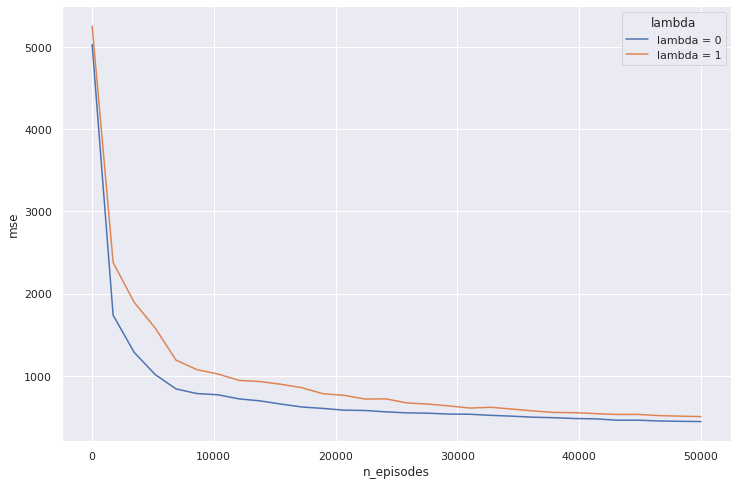

In [23]:
# Same Plotting but with only showing Lambda as 0 and 1
list_lambdas = [0, 1]
n_episodes = 50_000
plot_mse(optimal_Q, n_episodes=n_episodes, list_lambdas=list_lambdas)

## Comments on the MCC and SARSA comparison

* The SARSA's Lamba parameter, also called Trace Factor, allows to choose the step size when applying the TD Learning. So, a higher Lambda value means bigger "steps".

* When we have set SARSA's Lamba to 1, we comeback to the MCC approach, which is taking 1 "step" at a time.

# The Optimal Choices found

In [24]:
# Finding the optimal choices
def plot_opt_policy(lamb, n_episodes):
    sarsa_Q = SARSA(lamb=lamb, n_episodes=n_episodes, N_0=100)
    sarsa_Q.learn_q_value_function()
    df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
    states = list(sarsa_Q.Q.keys())
    for i in range(len(states) - dealer_score_max*2):
        best_action = max(sarsa_Q.Q[states[i]], key=sarsa_Q.Q[states[i]].get)
        df.loc[i] = (states[i][0], states[i][1], best_action)

    df_pivot = df.pivot("player_score", "dealer_showing", "best_action")
    return df_pivot

In [25]:
# Print optimal choices found for 50 000 games
plot_opt_policy(lamb=0, n_episodes=50_000)

dealer_showing,1,2,3,4,5,6,7,8,9,10,11
player_score,,,,,,,,,,,
1,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
2,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
3,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
4,hit,hit,stick,hit,hit,hit,hit,stick,hit,hit,hit
5,hit,hit,hit,stick,hit,hit,stick,stick,stick,stick,hit
6,hit,hit,hit,hit,hit,hit,stick,hit,hit,hit,hit
7,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
8,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
9,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit


In [26]:
# Print optimal choices found for 100 000 games
plot_opt_policy(lamb=0,n_episodes=100_000)

dealer_showing,1,2,3,4,5,6,7,8,9,10,11
player_score,,,,,,,,,,,
1,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
2,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
3,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
4,hit,hit,hit,stick,hit,hit,stick,hit,hit,hit,hit
5,hit,hit,hit,hit,hit,stick,stick,hit,hit,hit,hit
6,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
7,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
8,hit,hit,hit,hit,stick,hit,hit,hit,hit,hit,hit
9,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit


In [27]:
# Print optimal choices found for 1 000 000 games
plot_opt_policy(lamb=0,n_episodes=1_000_000)

dealer_showing,1,2,3,4,5,6,7,8,9,10,11
player_score,,,,,,,,,,,
1,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
2,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
3,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
4,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
5,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
6,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
7,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
8,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
9,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit,hit
